# Potato Disease Classification

### *Getting the DATASET from Kaggle*

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d raghul21bec1662/projrct-cnn

 53% 20.0M/37.8M [00:00<00:00, 64.4MB/s]
100% 37.8M/37.8M [00:00<00:00, 87.9MB/s]


### *Unziping the DATASET*

In [ ]:
!unzip /content/projrct-cnn.zip

Archive:  /content/projrct-cnn.zip
  inflating: Potato_Dataset/Early_Blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: Potato_Dataset/Early_Blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: Potato_Dataset/Early_Blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: Potato_Dataset/Early_Blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: Potato_Dataset/Early_Blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: Potato_Dataset/Early_Blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: Potato_Dataset/Early_Blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: Potato_Dataset/Early_Blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: Potato_Dataset/Early_Blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: Potato_Dataset/Early_Blight/03b0d3

### *Importing the necessary Modules*

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

### *Importing the DATASET into Tensorflow*

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 0 2 0 2 0 0 2 0 0 1 2 2 0 0]


### *Visualize some of the images from our dataset*

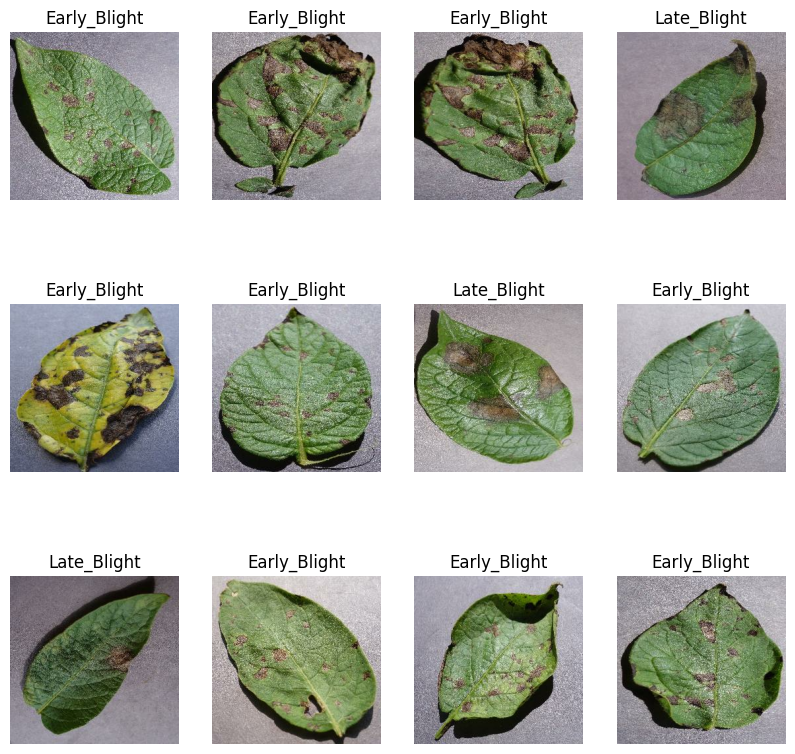

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### *Spliting the Dataset*

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

### *Cache, Shuffle, and Prefetch the Dataset*

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## *Model Building*

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### *Data Augmentation*

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### *Applying Data Augmentation to Train Dataset*

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### ***CNN Model Architecture***

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

###*Compiling the Model*

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 213s 4s/step - loss: 0.8340 - accuracy: 0.5469 - val_loss: 0.6884 - val_accuracy: 0.6771
Epoch 2/10
54/54 [==============================] - 204s 4s/step - loss: 0.5991 - accuracy: 0.7407 - val_loss: 0.5507 - val_accuracy: 0.7448
Epoch 3/10
54/54 [==============================] - 203s 4s/step - loss: 0.4981 - accuracy: 0.7894 - val_loss: 0.4891 - val_accuracy: 0.7760
Epoch 4/10
54/54 [==============================] - 204s 4s/step - loss: 0.4068 - accuracy: 0.8304 - val_loss: 0.5418 - val_accuracy: 0.8021
Epoch 5/10
54/54 [==============================] - 204s 4s/step - loss: 0.3689 - accuracy: 0.8495 - val_loss: 0.3736 - val_accuracy: 0.8698
Epoch 6/10
54/54 [==============================] - 206s 4s/step - loss: 0.2505 - accuracy: 0.9010 - val_loss: 0.6769 - val_accuracy: 0.7240
Epoch 7/10
54/54 [==============================] - 199s 4s/step - loss: 0.1994 - accuracy: 0.9294 - val_loss: 0.2079 - val_accuracy: 0.9115
Epoch 8/10
54

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 10s 1s/step - loss: 0.1553 - accuracy: 0.9609


In [ ]:
scores

[0.1553206592798233, 0.9609375]

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8340210914611816,
 0.5991488695144653,
 0.49809300899505615,
 0.4067521393299103,
 0.3688788115978241]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

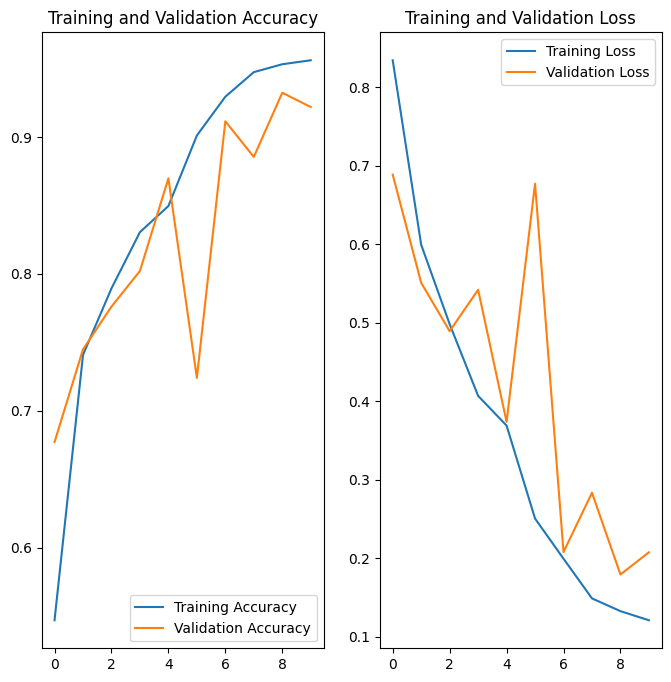

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
img = image.load_img('/content/Potato_Dataset/Early_Blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG',target_size =(256,256))

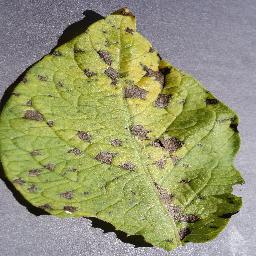

In [ ]:
img

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(model.predict(x))
op =['Early','Healthy','Late']
op[pred]

1/1 [==============================] - 0s 413ms/step


'Early'

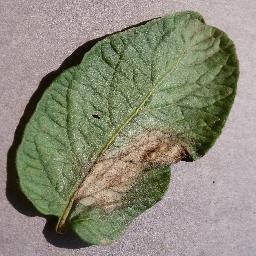

In [ ]:
img = image.load_img('/content/Potato_Dataset/Late_Blight/025f3c76-6d6c-4dad-ba22-e3e72d084ef1___RS_LB 3105.JPG',target_size =(256,256))
img

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(model.predict(x))
op =['Early','Healthy','Late']
op[pred]

1/1 [==============================] - 0s 47ms/step


'Late'

In [ ]:
model.save("poroject1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
